In [3]:
from pathlib import Path
import ipywidgets as widgets
from ipyleaflet import Map, GeomanDrawControl, ScaleControl, Map, basemaps
from datetime import datetime

from synth import SimulationInputs
from synth.core import create_simulation_data
from synth import Bbox

# synth: error: unrecognized arguments: -f /Users/staniewi/Library/Jupyter/runtime/kernel-....
sys.argv = []

In [5]:
# Create the map
m = Map(
    center=[38, -120],
    zoom=7,
    basemap=basemaps.Esri.WorldImagery,
    layout=widgets.Layout(width="70%", height="500px"),
)
m.add(ScaleControl(position="bottomright"))

# Add draw control for the rectangle
draw_control = GeomanDrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "fillOpacity": 0.2,
    }
}
m.add_control(draw_control)
common_kw = dict(disabled=False, style={"description_width": "initial"})

# Variable to store the bounding box
bounding_box = None

# Callback for when a shape is drawn
def handle_draw(self, action, geo_json):
    global bounding_box
    if action == "create":
        coords = geo_json[-1]["geometry"]["coordinates"][0]
        lons = [coord[0] for coord in coords]
        lats = [coord[1] for coord in coords]

        left = min(lons)
        right = max(lons)
        bottom = min(lats)
        top = max(lats)

        bounding_box = Bbox(left, bottom, right, top)
        select_button.disabled = False

draw_control.on_draw(handle_draw)

output_dir = widgets.Text(description="Output directory", value=str(Path().resolve()))
# Create date picker for start date
start_date = widgets.DatePicker(
    description="Start Date:", value=datetime(2020, 1, 1), **common_kw
)

# Create numeric input for dt (days)
dt = widgets.BoundedIntText(
    value=12, min=1, max=365, step=1, description="dt (days):", **common_kw
)

# Create numeric input for number of dates
num_dates = widgets.BoundedIntText(
    value=10, min=2, max=100, step=1, description="Number of Dates:", **common_kw
)

# Create numeric inputs for output resolutions
res_y = widgets.BoundedFloatText(
    value=10, min=1, max=100, step=1, description="Y Resolution (m):", **common_kw
)
res_x = widgets.BoundedFloatText(
    value=5, min=1, max=100, step=1, description="X Resolution (m):", **common_kw
)

include_turbulence = widgets.Checkbox(value=True, description="Add turbulence", **common_kw)
include_deformation = widgets.Checkbox(value=True, description="Add deformation", **common_kw)
include_ramps = widgets.Checkbox(value=True, description="Add ramps", **common_kw)
# include_stratified = widgets.Checkbox(value=True, description="include stratified", **common_kw)

max_defo_amplitude = widgets.BoundedFloatText(
    value=10, min=0, max=100, step=0.1, description="Max defo. bowl amplitude (rad):", **common_kw
)
max_turbulence_amplitude = widgets.BoundedFloatText(
    value=5, min=0, max=100, step=0.1, description="Max turbulence noise amplitude (rad):", **common_kw
)
max_ramp_amplitude = widgets.BoundedFloatText(
    value=1, min=0, max=10, step=0.1, description="Max ramp amplitude (rad):", **common_kw
)

# Create output widget
output = widgets.Output()

# Create select button
select_button = widgets.Button(
    description="Select", disabled=True, button_style="success"
)

inputs = None


def _calc_slc_shape(bbox, res_y, res_x):
    left, bottom, right, top = bbox
    up_x = 30 / res_x
    up_y = 30 / res_y
    # SRTM 30 meters has 3600 pixels per degree tile
    degrees_for_30_meter_pixel = 1 / 3600
    pixels_x = (right - left) / degrees_for_30_meter_pixel * up_x
    pixels_y = (top - bottom) / degrees_for_30_meter_pixel * up_y
    return int(round(pixels_y)), int(round(pixels_x))


# Function to handle select button click
def on_select_button_clicked(b):
    global inputs
    try:
        inputs = SimulationInputs(
            output_dir=output_dir.value,
            start_date=start_date.value,
            dt=dt.value,
            num_dates=num_dates.value,
            res_y=res_y.value,
            res_x=res_x.value,
            bounding_box=bounding_box,
            include_turbulence=include_turbulence.value,
            max_turbulence_amplitude=max_turbulence_amplitude.value,
            include_ramps=include_ramps.value,
            max_ramp_amplitude=max_ramp_amplitude.value,
            include_deformation=include_deformation.value,
            max_defo_amplitude=max_defo_amplitude.value,
            # include_stratified=include_stratified.value,
        )
        with output:
            output.clear_output()
            slc_shape = _calc_slc_shape(bounding_box, res_y.value, res_x.value)
            print(f"Approximate SLC shape: {slc_shape}")
            print(f"Approx. swath size: {slc_shape[0] * res_y.value / 1000:.1f}, {slc_shape[1] * res_x.value / 1000:.1f} km")
            print("Simulation inputs selected:")
            print(inputs.model_dump_json(indent=2))
            if not inputs.output_dir.exists():
                print(f"Creating {inputs.output_dir}")
                inputs.output_dir.mkdir(parents=True, exist_ok=True)
            with open(inputs.output_dir / "simulation_params.json", "w") as f:
                f.write(inputs.model_dump_json(indent=2))
    except Exception as e:
        with output:
            print(f"Error: {str(e)}")


select_button.on_click(on_select_button_clicked)

# Layout
left_column = widgets.VBox(
    [
        widgets.HTML("<h3>Simulation Parameters</h3>"),
        output_dir,
        start_date,
        dt,
        num_dates,
        res_y,
        res_x,
        include_turbulence,
        max_turbulence_amplitude,
        include_deformation,
        max_defo_amplitude,
        include_ramps,
        max_ramp_amplitude,
        # include_stratified,
        select_button,
        output,
    ],
    layout=widgets.Layout(width="400px"),
)

right_column = widgets.VBox(
    [widgets.HTML("<h3>Map Selection</h3>"), m],
    layout=widgets.Layout(width="600px", height="600px"),
)

layout = widgets.HBox([left_column, right_column])

# Display the widget
display(layout)

In [6]:
with open("simulation_params.json") as f:
    inputs = SimulationInputs.model_validate_json(f.read())

In [7]:
%%time
noisy_stack = create_simulation_data(inputs)

2024-07-02 12:35:43,780 - synth - INFO - Upsampling by (6, 6)
2024-07-02 12:35:43,781 - synth - INFO - Getting Rhos, Tau rasters
2024-07-02 12:35:46,856 - synth.global_coherence - INFO - Raster data saved to /Users/staniewi/repos/synth/notebooks/input_layers/rho_winter.tif
2024-07-02 12:35:46,859 - synth.global_coherence - INFO - Reading from /Users/staniewi/repos/synth/notebooks/input_layers/rho_winter.tif
2024-07-02 12:35:55,322 - synth.global_coherence - INFO - Raster data saved to /Users/staniewi/repos/synth/notebooks/input_layers/amp_winter.tif
2024-07-02 12:35:56,301 - synth.global_coherence - INFO - Raster data saved to /Users/staniewi/repos/synth/notebooks/input_layers/tau_winter.tif
2024-07-02 12:36:01,127 - synth.global_coherence - INFO - Raster data saved to /Users/staniewi/repos/synth/notebooks/input_layers/tau_spring.tif
2024-07-02 12:36:01,128 - synth.global_coherence - INFO - Raster data saved to /Users/staniewi/repos/synth/notebooks/input_layers/rho_spring.tif
2024-07-0

  0%|          | 0/20 [00:00<?, ?it/s]

2024-07-02 12:37:15,658 - synth - INFO - Generating deformation


  0%|          | 0/20 [00:00<?, ?it/s]

2024-07-02 12:37:19,076 - synth - INFO - Generating ramps
2024-07-02 12:37:23,622 - synth - INFO - Creating coherence matrices for each pixel


  0%|          | 0/506 [00:00<?, ?it/s]

CPU times: user 7min 12s, sys: 2min 47s, total: 10min
Wall time: 7min 14s


# Plot results and interferograms

In [10]:
import rasterio as rio
import h5py
import matplotlib.pyplot as plt
from functools import partial
import jax.numpy as jnp
from jax import jit, lax, vmap


@partial(jit, static_argnums=(1, 2, 3))
def take_looks(image, row_looks, col_looks, average=False):
    # Ensure the image has a channel/batch dimension (assuming grayscale image)
    # Add a (batch, ..., channel) dimensions to make NHWC
    image = image[jnp.newaxis, ..., jnp.newaxis]

    # Create a kernel filled with ones
    # Kernel shape: HWIO (height, width, input_channels, output_channels)
    kernel = jnp.ones((row_looks, col_looks, 1, 1), dtype=image.dtype)

    # With each window, we're jumping over by the same number of pixels
    strides = (row_looks, col_looks)
    result = lax.conv_general_dilated(
        image,
        kernel,
        window_strides=strides,
        padding="SAME",
        dimension_numbers=("NHWC", "HWIO", "NHWC"),
    )

    # Average if required
    if average:
        result /= row_looks * col_looks

    return result.squeeze()

## SLC Ampltudes, interferogram phases

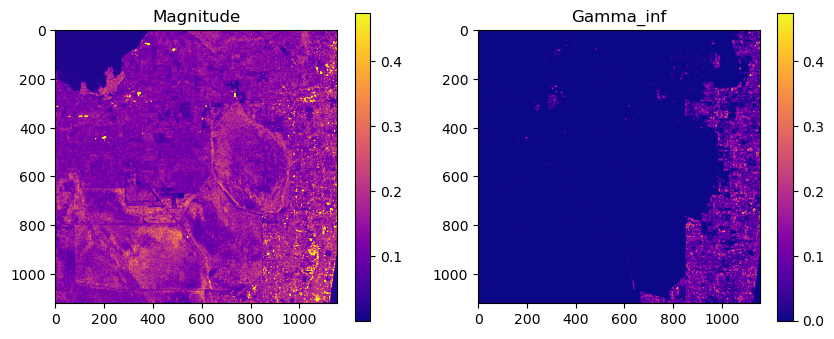

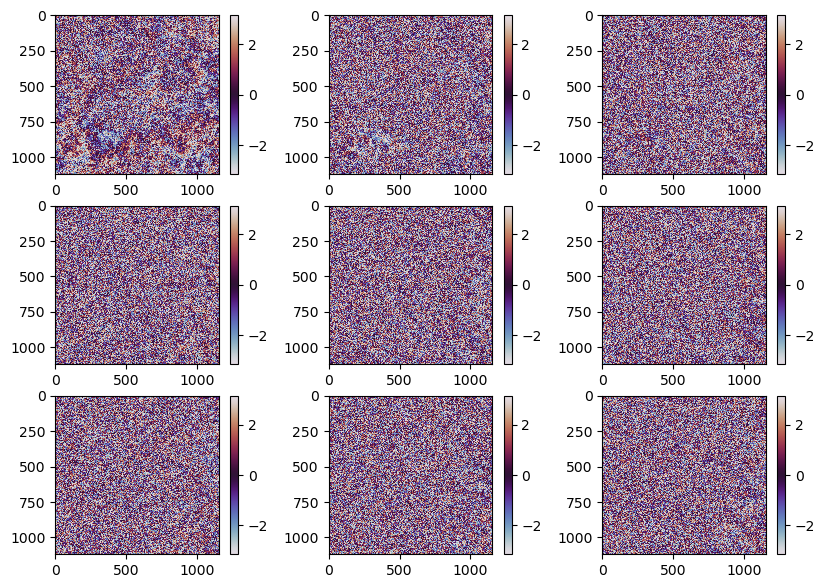

In [22]:
fig2, axes2 = plt.subplots(ncols=2, figsize=(10, 4))
fig, axes = plt.subplots(3, 3, figsize=(10, 7))

slc_files = sorted(Path("slcs/").glob("*.tif"))
with rio.open(slc_files[0]) as src:
    s0 = src.read(1)
# with rio.open("input_layers/rho_min.tif") as src:
with rio.open("input_layers/rho_shrunk.tif") as src:
    rho_inf = src.read(1)
    
mag = np.abs(s0)
titles = ['Magnitude', 'Gamma_inf']
for img, ax, t in zip([mag, rho_inf], axes2.ravel(), titles):
    axim = ax.imshow(img[::5, ::5], cmap='plasma', vmax=np.nanpercentile(mag, 99))
    fig2.colorbar(axim, ax=ax)
    ax.set_title(t)

for f, ax in zip(slc_files[1:], axes.ravel()):
    with rio.open(f) as src:
        s1 = src.read(1)

    ifg = take_looks(s0 * s1.conj(), 5, 5)
    axim = ax.imshow(np.angle(ifg), cmap='twilight', interpolation='nearest')
    fig.colorbar(axim, ax=ax)


In [17]:
def plot_hdf5(fn, cmap="RdBu", nplots=(3, 3), subsample=4):
    fig, axes = plt.subplots(*nplots, figsize=(10, 7))
    with h5py.File(fn) as hf:
        data = hf['data'][:]
        
        for idx, ax in enumerate(axes.ravel()):
            axim = ax.imshow(data[idx, ::subsample, ::subsample], cmap='RdBu')
            fig.colorbar(axim, ax=ax)
    # 
    fig.suptitle(fn)

## Noise layers

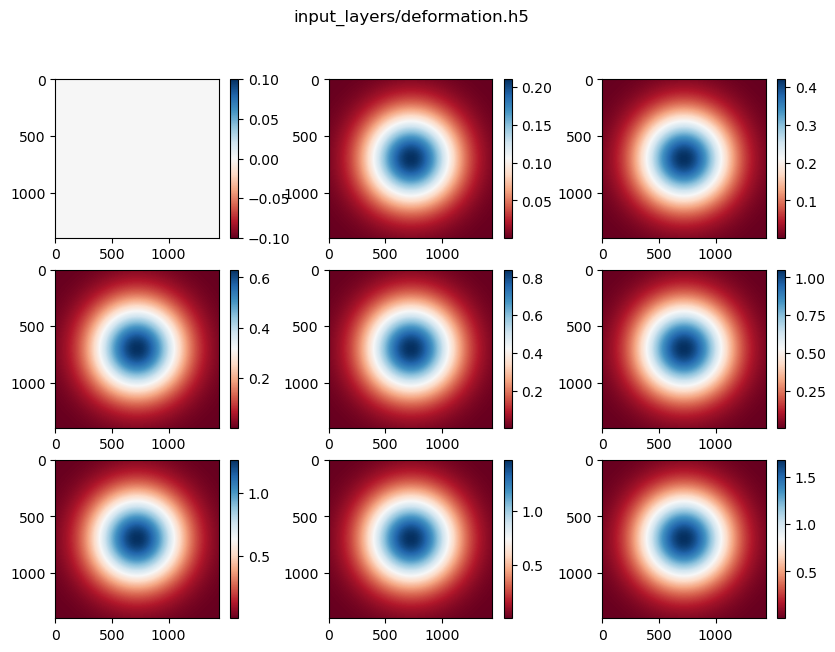

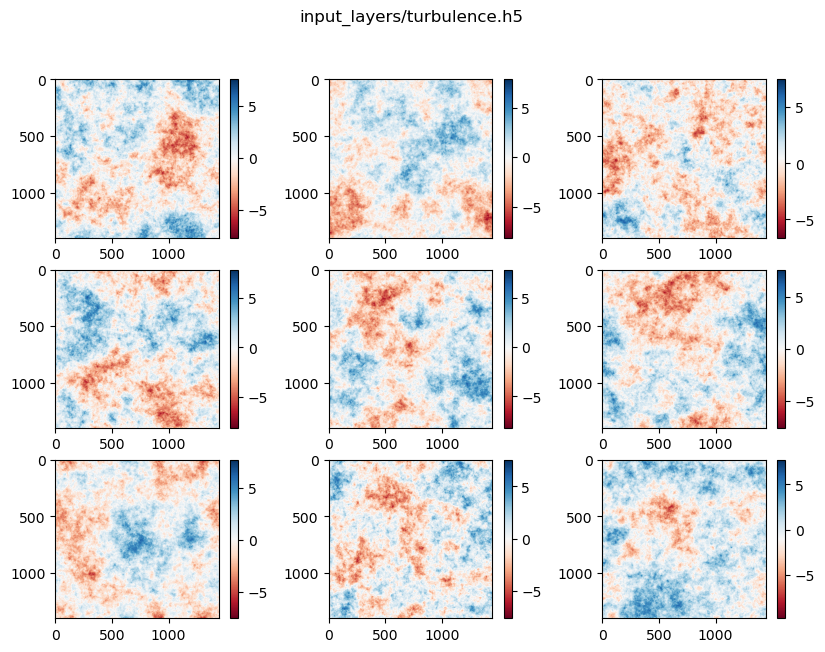

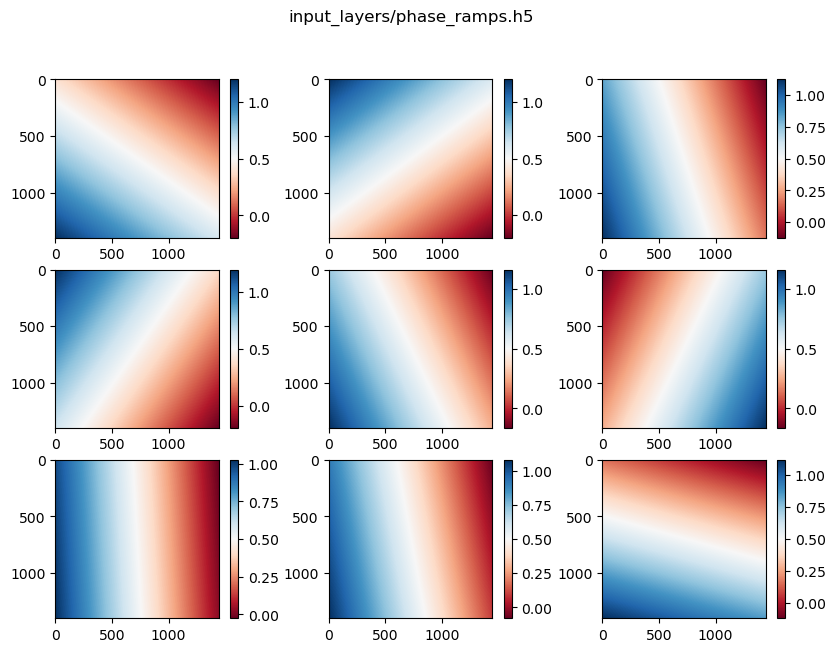

In [24]:
plot_hdf5("input_layers/deformation.h5")
plot_hdf5("input_layers/turbulence.h5")
plot_hdf5("input_layers/phase_ramps.h5")